# Image Classifier
_Ucadity Intro to Deep Learning Project_

In [31]:
# Imports here
import torch
from torchvision import datasets, transforms, models
from torch import nn, optim
import torch.nn.functional as F
!pip install helper
import helper
import json
from workspace_utils import active_session
from collections import OrderedDict
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [32]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
tune_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [33]:
# Define the transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(p=0.25),
                                      transforms.RandomVerticalFlip(p=0.25),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
tune_data = datasets.ImageFolder(tune_dir, transform=test_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# Using the image datasets and the trainforms, define the dataloaders
batch_size = 64
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
tuneloader = torch.utils.data.DataLoader(tune_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [11]:
# Display an image
dataiter = iter(trainloader)
images, labels = dataiter.next() # gives me all the image and corr labels
print(f'Image type: {type(images)}')
print(f'Image shape: {images.shape}')
print(f'Label shape: {labels.shape}')



Image type: <class 'torch.Tensor'>
Image shape: torch.Size([30, 3, 224, 224])
Label shape: torch.Size([30])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


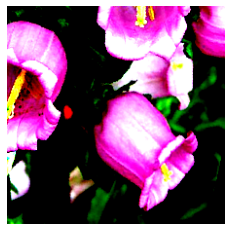

In [59]:
i1 = images[1]
plt.axis('off')
plt.imshow(i1.numpy().squeeze().transpose(1,2,0));

In [ ]:
# dataset
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

<ipython-input-58-9a26ce6d6759>:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nr_images/3, nr_images/3, idx)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for 

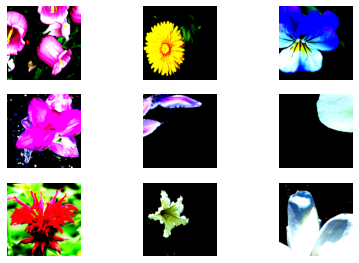

In [58]:
plt.figure()
nr_images = 9

for idx in range(1, nr_images + 1):
    #print(idx)
    plt.subplot(nr_images/3, nr_images/3, idx)
    #i1 = images[i,:,:,:]
    #i1.shape
    plt.tight_layout()
    plt.axis('off');
    plt.imshow(images[idx].numpy().squeeze().transpose(1,2,0));

plt.show();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


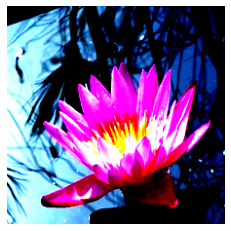

In [ ]:
# label for classification
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [ ]:
# -- BUILD THE MODEL
# Run on GPU if possible
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

# Load the pre-built and pre-trained model
model = models.vgg16(pretrained=True)

# Freeze the parameters for the pre-trained model, so we dont backprop through them
for param in model.parameters():
    param.requires_grad = False
    
# Define model
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(25088, 4096)),
    ('relu1', nn.ReLU()),
    ('do1', nn.Dropout(0.2)),
    ('fc2', nn.Linear(4096, 102)),
    ('output', nn.LogSoftmax(dim=1))
]))

# Define the model to be trained
model.classifier = classifier # the model pre-trained model VGG doesnt have .fc but .classifier

# Define loss function
criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
 
# Send model to device
model.to(device)

In [ ]:
# -- TRAIN THE MODEL
import timeit

start = timeit.timeit()

# For long running code keep the session active
with active_session():
    
    # Def of variables
    epochs = 2 # nr of trainings
    steps = 0
    running_loss = 0
    print_every = 5
    run_accuracy = 0
    train_losses, tune_losses = [], []
    train_accuracy, tune_accuracy = [], []
    
    # Training
    for epoch in range(epochs): # nr of traning times
        
        for inputs, labels in tuneloader: # loop through the data
            
            steps += 1 # train steps
            
            # Move input and label tensors to the default device (GPU if available)
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Zero the gradients - very important
            optimizer.zero_grad()
            
            # Forward pass -> log probabilities
            logps = model.forward(inputs)
            
            # Define loss
            loss = criterion(logps, labels)
            
            # Backward pass
            loss.backward()
            
            # Take a step towards lower loss
            optimizer.step()
            
            # Keep track on the total loss
            running_loss += loss.item()
            
            # calculate the accuracy
            ps = torch.exp(logps) # get the actual probability
            top_p, top_class = ps.topk(1, dim=1) # top probabilities and classes

            equals = top_class == labels.view(*top_class.shape) # check how many images which have the correct classification. 
            # That *top_class.shape is passing all of the items in the top_class.shape into the view function call as separate arguments, without us even needing to know how many arguments are in the list. For example if the top_class has a shape say (32, 1), so *top_class.shape will pass 32, 1 to view function. Now this is as good as passing (top_class.shape[0],top_class.shape[1]). labels.view(top_class.shape[0],top_class.shape[1]) is equal to labels.view(*top_class.shape). The labels.view(*top_class.shape) is very useful because we dont have to know the exact shape for us to reshape them, we just use * and it will pack everything into a list and pass on to the view function for reshaping

            run_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            # after getting the top_class of the top_probability from torch.exp(output), we equal the top_class with the images labels (targets) to check if they match or not. The result from this equality is binary values [0,1]. Does this mean that 1 refers to class-label matching and 0 refers to class-label mismatching? Yes
            
            # Tune the model every print_every 5 times
            if steps % print_every == 0:
                tune_loss = 0
                accuracy = 0
                model.eval() # set model in evaluation mode
                
                with torch.no_grad(): # reduces memory usage - we dont need to calculate the gradients in evaluation mode
                    
                    for images, labels in tuneloader:
                        
                        # Move images and labels tensors to the default device (GPU if available)
                        images = images.to(device)
                        labels = labels.to(device)
                        
                        # Calculate the loss
                        log_ps = model(images) # log of probability
                        loss = criterion(log_ps, labels)
                        tune_loss += loss.item()

                        # calculate the accuracy
                        ps = torch.exp(log_ps) # get the actual probability
                        top_p, top_class = ps.topk(1, dim=1) # top probabilities and classes
                        
                        equals = top_class == labels.view(*top_class.shape) # check how many images which have the correct classification. 
                        # That *top_class.shape is passing all of the items in the top_class.shape into the view function call as separate arguments, without us even needing to know how many arguments are in the list. For example if the top_class has a shape say (32, 1), so *top_class.shape will pass 32, 1 to view function. Now this is as good as passing (top_class.shape[0],top_class.shape[1]). labels.view(top_class.shape[0],top_class.shape[1]) is equal to labels.view(*top_class.shape). The labels.view(*top_class.shape) is very useful because we dont have to know the exact shape for us to reshape them, we just use * and it will pack everything into a list and pass on to the view function for reshaping

                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                        # after getting the top_class of the top_probability from torch.exp(output), we equal the top_class with the images labels (targets) to check if they match or not. The result from this equality is binary values [0,1]. Does this mean that 1 refers to class-label matching and 0 refers to class-label mismatching? Yes

                train_losses.append(running_loss/len(trainloader))
                tune_losses.append(tune_loss/len(tuneloader))
                train_accuracy.append(run_accuracy/len(trainloader))
                tune_accuracy.append(accuracy/len(tuneloader))
                        
                print(f"Epoch {epoch+1}/{epochs}.. "
                      f"Train loss: {running_loss/print_every:.3f}.. "
                      f"Tune loss: {tune_loss/len(tuneloader):.3f}.. "
                      f"Train accuracy: {run_accuracy/len(trainloader):.3f}"
                      f"Tune accuracy: {accuracy/len(tuneloader):.3f}")
            
                running_loss = 0
                model.train()

                
end = timeit.timeit()
print(f'Tid: {end - start}')

In [ ]:
# Visualize the loss 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss');
plt.plot(tune_losses, label='Tuning loss');
plt.legend(frameon=False)

In [ ]:
# Visualize the accuracy
plt.plot(train_accuracy, label='Training accuracy');
plt.plot(tune_accuracy, label='Tuning accuracy');
plt.legend(frameon=False)

In [ ]:
# -- TEST THE MODEL

test_loss = 0
accuracy = 0
model.eval() # set model in evaluation mode

with torch.no_grad(): # reduces memory usage - we dont need to calculate the gradients in evaluation mode
                    
    for images, labels in testloader:

        # Move images and labels tensors to the default device (GPU if available)
        images = images.to(device)
        labels = labels.to(device)

        # Calculate the loss
        log_ps = model(images) # log of probability
        loss = criterion(log_ps, labels)
        test_loss += loss.item()

        # calculate the accuracy
        ps = torch.exp(log_ps) # get the actual probability
        top_p, top_class = ps.topk(1, dim=1) # top probabilities and classes

        equals = top_class == labels.view(*top_class.shape) # check how many images which have the correct classification. 
        # That *top_class.shape is passing all of the items in the top_class.shape into the view function call as separate arguments, without us even needing to know how many arguments are in the list. For example if the top_class has a shape say (32, 1), so *top_class.shape will pass 32, 1 to view function. Now this is as good as passing (top_class.shape[0],top_class.shape[1]). labels.view(top_class.shape[0],top_class.shape[1]) is equal to labels.view(*top_class.shape). The labels.view(*top_class.shape) is very useful because we dont have to know the exact shape for us to reshape them, we just use * and it will pack everything into a list and pass on to the view function for reshaping

        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        # after getting the top_class of the top_probability from torch.exp(output), we equal the top_class with the images labels (targets) to check if they match or not. The result from this equality is binary values [0,1]. Does this mean that 1 refers to class-label matching and 0 refers to class-label mismatching? Yes    

print(f"Test loss: {test_loss/len(testloader):.3f}.. "
      f"Test accuracy: {accuracy/len(testloader):.3f}")

In [ ]:
# -- SAVE THE CHECKPOINT

# Define the classifier definitions
model.class_to_idx = train_data.class_to_idx

# Save the checkpoint/model 
checkpoint = {'arch': 'vgg16',
              'state_dict': model.state_dict(),
              'optimizer': optimizer.state_dict(),
              'class_to_idx': train_data.class_to_idx,
              'epochs': epochs,
              'learning_rate': optimizer.state_dict()['param_groups'][0]['lr'],
              'input_size': 25088,
              'output_size': 102,
              'hidden_layers': 4096,
              'state_dict': model.state_dict()}

name = 'checkpoint3.pth'
torch.save(checkpoint, name)

In [ ]:
# --- LOADING THE CHECKPOINT & REBUILDING THE MODEL
model = torch.load(name)
#model.keys()

def load_model(filepath):
    
    # Run on GPU if possible
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    # Assign the model data into a variable
    checkpoint = torch.load(filepath)
    print(checkpoint.keys())

    # Assign the name of the pretrained model as string
    new_model = models.vgg16(pretrained=True) # How to create from parameter?

    # Rebuild the model
    classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(checkpoint['input_size'], checkpoint['hidden_layers'])),
        ('relu1', nn.ReLU()),
        ('do1', nn.Dropout(0.2)),
        ('fc2', nn.Linear(checkpoint['hidden_layers'], checkpoint['output_size'])),
        ('output', nn.LogSoftmax(dim=1))
        ]))

    # Define new_model classifier
    new_model.classifier = classifier
    
    # Define new_model weights
    new_model.load_state_dict(checkpoint['state_dict'])

    # Send to the GPU?
    new_model.to(device)

    # Loading model to device
    new_model.to(device)
    
    return new_model 

new_model = load_model(name)
print(new_model)

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [ ]:
def process_image(img_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Open 1 image
    img = Image.open(img_path)
    print(f'Image org size: {img.size}')
    
    # Scale
    width, height = img.size
    print(f'Width: {width}') # [0]
    print(f'Height: {height}') # [1]
    
    smallest_len = 256
    
    if height >= width:
        img.thumbnail((smallest_len, 1000)) # Change widht to 256
    else:
        img.thumbnail((1000, smallest_len)) # Change height to 256
        
    print(f'Image size width: {img.size}')
    
    # Crop
    crop_size = 224 
    left = (width - crop_size)/2 # zero is in the top left corner
    top = (height - crop_size)/2
    right = left + crop_size
    bottom = top + crop_size
    
    img = img.crop((left, top, right, bottom))
    print(f'Image size: {img.size}')
    
    # Change color channels (typically 0-255, but model expects floats 0-1)
    np_img = np.array(img)/255 # Normalize manually
    print(f'np_img size: {np_img.size}')
    
    # Normalize the color channels
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_img = (np_img - mean)/std
    print(f'np_img size: {np_img.size}')
    
    # Transpose the color channels (pytorch expects color channels to be the first dimension, in PIL image and np array its the 3rd)
    processed_img = np_img.transpose(2,0,1)
    print(f'processed_img size: {processed_img.size}')
    
    # Modify the output to a tensor
    tensor_img = torch.from_numpy(processed_img)
    print(f'tensor_img size: {tensor_img.size}')
    
    return tensor_img

img_path = 'flowers/train/1/image_06734.jpg'
image = process_image(img_path)
print(f'Output size: {image.size}')
image

In [ ]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy()[0].transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    ax.imshow(image)

    return ax

imshow(image);

In [ ]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Set the model in evaluation mode
    model.eval()
        
    # Import image
    img = Image.open(image_path)
    
    # Process Image - From jpeg to tensor
    processed_img = process_image(img)
    print(processed_img)
    
    # Flatten tensor
    img = processed_img.view(processed_img.numpy(), -1)
    
    # Turn off auto_grad
    with torch.no_grad():
        output = model.forward(img)

    return

image_path = 'flowers/train/1/image_06734.jpg'
predict(image_path, new_model)